# Recurrent Neural Networks

So far, we have only worked with static data. Even if data had a temporal nature, we have simply concatenated inputs and looked at a piece of history all at once. When using a dense network, all inputs are initially of equal importance and we leave it to the network to identify salient information. Albeit convolutional layers might help to impose some sense of order - a 1D convolutional layer might as well be interpreted as detecting a pattern in a timeseries - dense layers focus on the values of individual features, not whether values are swapped in the input. 

In order to keep track of temporal relations, for example to understand a sentence like "The movie seemed really BAD for the first few minutes, but turned out to be really GREAT.", a dense network might learn at best to equally weigh the words "bad" and "great", but will not be able to pick up on the "but".

This is different if a neural network could have state. In this case, a sentence could be processed word by word, each modifying the network state in some way. This is accomplished using so-called <i>recurrent neural networks</i>. A recurrent neural network uses a special kind of neuron, which sums the input $x_t$ at time $t$ with the value of the hidden state $h_{t-1}$ at the previous time step $t-1$ to compute a hidden state $h_t$ at time $t$. Both terms of this sum are weighed by weights W and U. The output of the recurrent layer is the hidden state $h_t$ weighed by a third weight V and ran through a second activation function. The equation below shows the computation of a RNN layer in vector form, passing the hidden states through a softmax activation.

$$h_t = \tanh(Wh_{t-1}+Ux_t)$$
$$y_t = softmax(Vh_t) $$

This relationship is shown in the diagram below. As a RNN cell is reusing its internal state $h_t$ in the next iteration, a network that looks back $N$ time-steps is modeled as $N$ cells that are laterally connected.

<center>
    <img src="figs/rnn.svg" width="50%">
</center>

As this is how an RNN is actually implemented, the data from all time steps is presented at the same time.  

In [177]:
from keras.layers import SimpleRNN
from keras.models import Sequential
import numpy as np

time_steps=5

model = Sequential()
model.add(SimpleRNN(units=1, input_shape=(time_steps,1), activation="tanh")) # build RNN that takes up to time_step values
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_96 (SimpleRNN)    (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


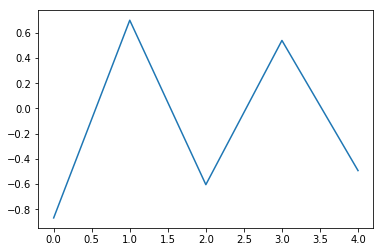

In [179]:
# Feeding the RNN with the following sequence (NB: the RNN is initialized with random weights)
# [1 0 0 0 0]
# [0 1 0 0 0]
# [0 0 1 0 0]
# [0 0 0 1 0]
# [0 0 0 0 1]

import matplotlib.pyplot as plt
output=np.zeros(time_steps)
for J in range(time_steps):
    I=np.zeros(time_steps)
    I[time_steps-J-1]=1
    # The input is of the form (batch_size, timesteps, input_dim), here (1,5,1)
    I=I[np.newaxis,:,np.newaxis]
    output[J]=model.predict(I)
plt.plot(output)

Creating the RNN model a couple of times (everytime using different random values) shows the many different ways the hidden value can develop in response to a train of '1'. 

## Training a RNN

A RNN that looks at, say, 5 timesteps one after each other, can be unfolded in 5 networks with one feeding into each other. It is this unfolded network that is trained using backpropagation, also known as <i>backpropagation through time</i>. Note that the weights remain the same during all time steps. The complication here is that we will again need to apply the chain rule, resulting into quickly vanishing gradients due to small values getting multiplied over and over again. There exist a series of more advanced network structures that serve as a drop-in replacement and have more favorable properties, specifically LSTMs and GRUs. 

When training an RNN, we are training an universal function approximator. Not only can we train the network to generate pattern, we can also train it to make decision on the output. The RNN can also be combined with additional dense layers that again classify the output. This is illustrated in two examples, <a href="https://github.com/correll/deep-learning/blob/master/examples/dynamic_problems/rnn_generate_random_text.ipynb">one generating random prose</a>, the other <a href="https://github.com/correll/deep-learning/blob/master/examples/dynamic_problems/rnn_analyze_timeseries.ipynb">dealing with a robot's force-torque data</a>.

# Bidirectional layers

It is often desirable to look at a time series not only from one, but from both ends at once. This is particularly intuitive when considering language in which getting the full context right away is particularly useful. In Keras, this can be accomplished by wrapping a recurrent layer into a <code>Bidirectional</code> wrapper. As you can see, the recurrent layer is simply replicated, doubling the number of parameters, and their outputs concatened (Keras has other options here). 

In [156]:
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import Activation

model = Sequential()
#model.add(SimpleRNN(10, return_sequences=True,input_shape=(5, 10)))
model.add(Bidirectional(SimpleRNN(10, return_sequences=True),input_shape=(5, 10)))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.summary()

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 5, 20)             420       
_________________________________________________________________
dense_8 (Dense)              (None, 5, 5)              105       
_________________________________________________________________
activation_7 (Activation)    (None, 5, 5)              0         
Total params: 525
Trainable params: 525
Non-trainable params: 0
_________________________________________________________________
